In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [40]:
# Download and load dataset
path = kagglehub.dataset_download("rabieelkharoua/alzheimers-disease-dataset")

print("Path to dataset files:", path)

csv_file = os.listdir(path)[0]
csv_path = os.path.join(path, csv_file)

# Load dataset and preprocess
data = pd.read_csv(csv_path)
data = data.drop(columns=['PatientID', 'DoctorInCharge'])

X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

Path to dataset files: /Users/franek/.cache/kagglehub/datasets/rabieelkharoua/alzheimers-disease-dataset/versions/1


## Korelacja Pearsona

#### Co to jest korelacja Pearsona?
Korelacja Pearsona mierzy liniową zależność między dwiema zmiennymi. Współczynnik korelacji Pearsona $r$ wyrażany jest wzorem:

$$
r = \frac{\sum{(X_i - \bar{X})(Y_i - \bar{Y})}}{\sqrt{\sum{(X_i - \bar{X})^2} \cdot \sum{(Y_i - \bar{Y})^2}}}
$$



- $ X_i $, $ Y_i $: Wartości zmiennych $ X $ i $ Y $,
- $ \bar{X} $, $\bar{Y} $: Średnie zmiennych $ X $ i $ Y $,
- $ r $: Przyjmuje wartości od $-1$ (silna ujemna zależność) do $1$ (silna dodatnia zależność).

**Cel**: Zrozumienie siły i kierunku liniowej zależności między cechami oraz między cechami a zmienną celu.


In [43]:
# Funkcja obliczająca współczynnik korelacji Pearsona
def pearson_correlation(x, y):
    if len(x) != len(y):
        raise ValueError("Wektory muszą mieć tę samą długość.")

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sqrt(np.sum((x - mean_x) ** 2)) * np.sqrt(np.sum((y - mean_y) ** 2))

    return 0 if denominator == 0 else numerator / denominator

# Funkcja do obliczania macierzy korelacji
def correlation_matrix(data, correlation_func):
    columns = data.columns
    matrix = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            matrix.loc[col1, col2] = correlation_func(data[col1], data[col2])

    return matrix.astype(float)

# Funkcja obliczająca korelacje między kolumnami a wektorem celu
def correlation_with_target(data, target, correlation_func):
    if len(data) != len(target):
        raise ValueError("Liczba wierszy w data i target musi być taka sama.")

    return pd.Series({col: correlation_func(data[col], target) for col in data.columns})

## Wizualizacja korelacji


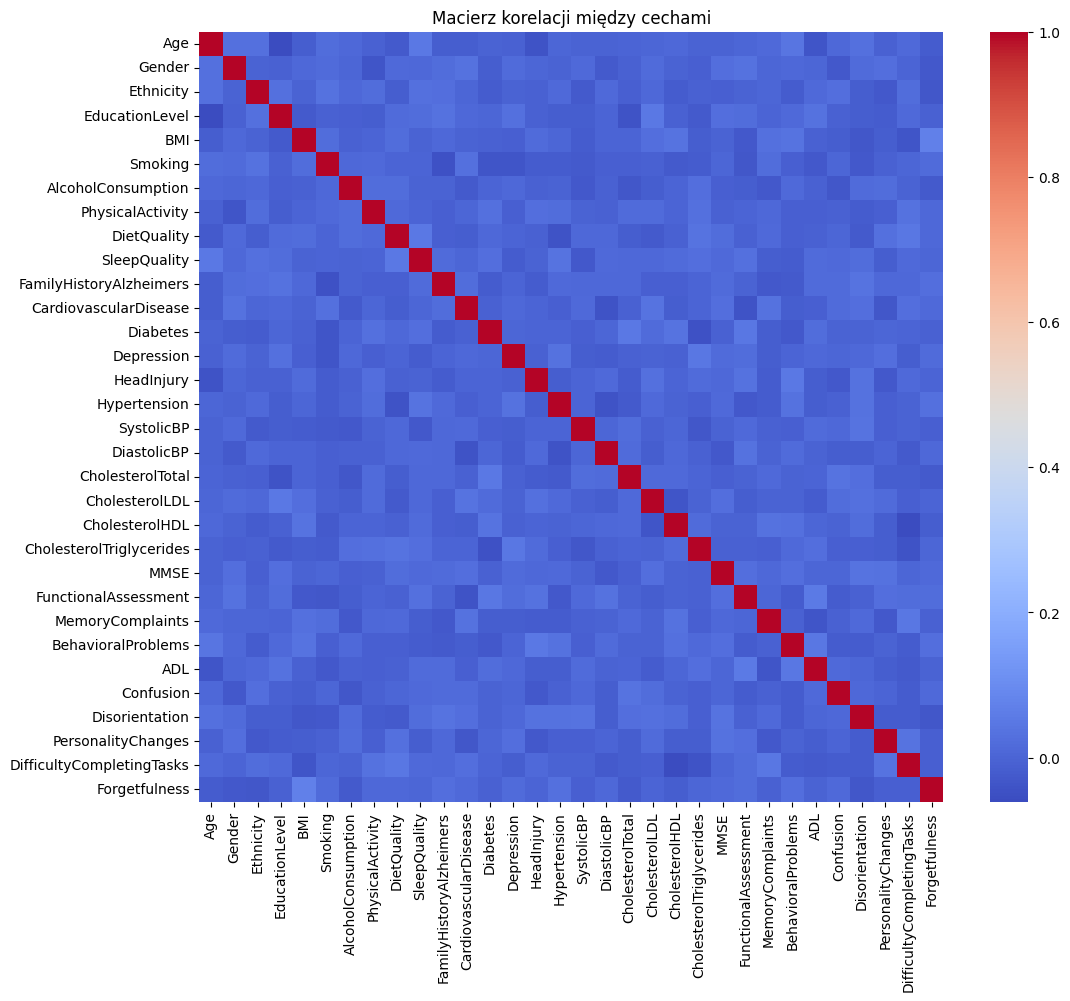

Korelacja cech z Diagnosis:
MemoryComplaints             0.306742
BehavioralProblems           0.224350
CholesterolHDL               0.042584
Hypertension                 0.035080
CardiovascularDisease        0.031490
BMI                          0.026343
CholesterolTriglycerides     0.022672
DifficultyCompletingTasks    0.009069
DietQuality                  0.008506
CholesterolTotal             0.006394
PhysicalActivity             0.005945
DiastolicBP                  0.005293
Forgetfulness               -0.000354
Smoking                     -0.004865
Age                         -0.005488
Depression                  -0.005893
AlcoholConsumption          -0.007618
Ethnicity                   -0.014782
SystolicBP                  -0.015615
Confusion                   -0.019186
PersonalityChanges          -0.020627
Gender                      -0.020975
HeadInjury                  -0.021411
Disorientation              -0.024648
Diabetes                    -0.031508
CholesterolLDL        

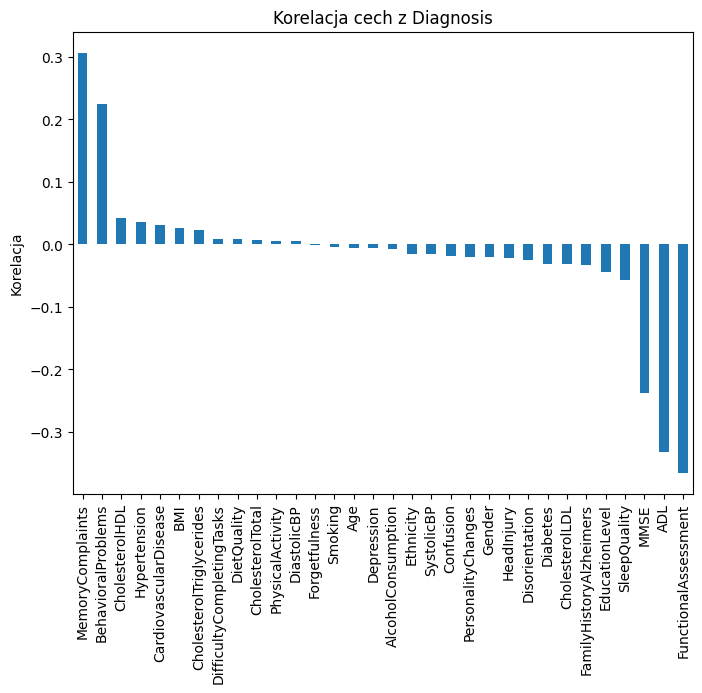

In [44]:
# Obliczanie macierzy korelacji
correlation_matrix_result = correlation_matrix(X, correlation_func=pearson_correlation)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_result, cmap="coolwarm", annot=False, cbar=True)
plt.title("Macierz korelacji między cechami")
plt.show()

# Obliczanie korelacji z wektorem celu
correlation_with_target_result = correlation_with_target(X, y, correlation_func=pearson_correlation).sort_values(ascending=False)

print("Korelacja cech z Diagnosis:")
print(correlation_with_target_result)

# Wizualizacja korelacji z wektorem celu
plt.figure(figsize=(8, 6))
correlation_with_target_result.plot(kind='bar')
plt.title("Korelacja cech z Diagnosis")
plt.ylabel("Korelacja")
plt.show()

#### Interpretacja wyników korelacji cech z `Diagnosis`

1. **Największa pozytywna korelacja:**
   - Cecha `MemoryComplaints` wykazuje najwyższą dodatnią korelację z wartością około 0.3. Oznacza to, że osoby z większą liczbą zgłoszonych problemów z pamięcią są bardziej skłonne do uzyskania pozytywnej diagnozy.

2. **Inne cechy o dodatniej korelacji:**
   - Cecha `BehavioralProblems` (około 0.22) również wskazuje na umiarkowaną dodatnią zależność.
   - Inne, jak `CholesterolHDL`, wykazują mniejsze, ale zauważalne dodatnie wartości korelacji.

3. **Największa negatywna korelacja:**
   - Cecha `FunctionalAssessment` ma największą wartość ujemnej korelacji, około -0.36. Sugeruje to, że osoby z lepszą oceną funkcjonalną mają mniejsze prawdopodobieństwo pozytywnej diagnozy.

4. **Inne cechy o negatywnej korelacji:**
   - Cecha `ADL` (około -0.33) również wykazuje istotną ujemną korelację, co może wskazywać, że codzienne funkcjonowanie jest kluczowym wskaźnikiem zdrowia.

5. **Niskie wartości korelacji:**
   - Niektóre cechy, takie jak `Gender` czy `HeadInjury`, mają korelacje bliskie zeru, co oznacza, że nie mają wyraźnej liniowej zależności z diagnozą.

---


## Test ANOVA

#### Co to jest ANOVA?
ANOVA (Analysis of Variance) to metoda statystyczna używana do porównania średnich więcej niż dwóch grup i oceny, czy różnice między nimi są statystycznie istotne. Test ANOVA zakłada:

1. Dane w grupach są normalnie rozkładowe.
2. Grupy mają porównywalne wariancje.

Wartość $ F $ w teście ANOVA jest obliczana jako:

$$
F = \frac{\text{Wariancja między grupami}}{\text{Wariancja wewnątrz grup}}
$$

- **Wariancja między grupami**: Zmienność wynikająca z różnic między średnimi grup.
- **Wariancja wewnątrz grup**: Zmienność wynikająca z różnic wewnątrz poszczególnych grup.

Wartość $ p $ informuje nas o prawdopodobieństwie, że zaobserwowane różnice wynikają z przypadku.

#### Dlaczego stosujemy ANOVA?
ANOVA pozwala ocenić, które cechy są statystycznie istotne w różnicowaniu grup (np. diagnoz w danych medycznych).

**Cel**: Wyodrębnienie cech istotnych statystycznie przy określonym poziomie istotności \( \alpha \).

In [45]:
# Inicjalizacja słownika na wyniki ANOVA
anova_results = {}

# Obliczanie wartości p dla każdej cechy
for column in X.columns:
    groups = [X[column][y == label] for label in np.unique(y)]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results[column] = p_val

# Konwersja wyników na ramkę danych
anova_df = pd.DataFrame(anova_results.items(), columns=['Feature', 'p-value'])

# Sortowanie cech według wartości p
anova_df.sort_values(by='p-value', inplace=True)

# Ustalanie poziomu istotności
alpha = 0.1
significant_features = anova_df[anova_df['p-value'] < alpha]

# Wyświetlenie istotnych cech
print(f"Istotne cechy (p < {alpha}):")
print(significant_features)


Istotne cechy (p < 0.1):
                 Feature       p-value
23  FunctionalAssessment  1.134785e-68
26                   ADL  1.396884e-56
24      MemoryComplaints  4.760134e-48
22                  MMSE  7.537248e-29
25    BehavioralProblems  6.369488e-26
9           SleepQuality  8.741801e-03
3         EducationLevel  4.155613e-02
20        CholesterolHDL  4.840127e-02
